# Notes for Lets-Plot
https://aeturrell.github.io/coding-for-economists/vis-common-plots.html

To improve some of the examples on Lets-Plot we suggest the changes described below.

In [1]:
import sys
!{sys.executable} -m pip install seaborn pandas-datareader

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import pandas_datareader.data as web
import datetime

from lets_plot.bistro import *
from lets_plot.mapping import *
from lets_plot import *


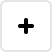
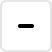
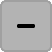
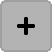
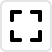
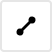
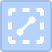
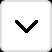
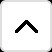
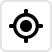
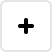
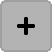
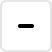
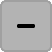
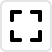
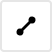
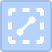
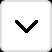
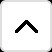
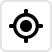

In [3]:
LetsPlot.setup_html()

## 1. geom_segment() instead of geom_path()
https://aeturrell.github.io/coding-for-economists/vis-common-plots.html#connected-scatter-plot


In [4]:
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2021, 1, 1)
code_dict = {
    "Vacancies": "LMJVTTUVUSA647N",
    "Unemployment": "UNRATE",
    "LabourForce": "CLF16OV",
}
list_dfs = [
    web.DataReader(value, "fred", start, end)
    .rename(columns={value: key})
    .groupby(pd.Grouper(freq="AS"))
    .mean()
    for key, value in code_dict.items()
]
df = pd.concat(list_dfs, axis=1)
df = df.assign(Vacancies=100 * df["Vacancies"] / (df["LabourForce"] * 1e3)).dropna()
df["Year"] = df.index.year
df.head()

Vacancies  Unemployment    LabourForce  Year
DATE                                                    
2001-01-01   3.028239      4.741667  143768.916667  2001
2002-01-01   2.387254      5.783333  144856.083333  2002
2003-01-01   2.212237      5.991667  146499.500000  2003
2004-01-01   2.470209      5.541667  147379.583333  2004
2005-01-01   2.753325      5.083333  149289.166667  2005

In [5]:
path_df = df.iloc[:-1].reset_index(drop=True).join(
    df.iloc[1:].reset_index(drop=True), lsuffix='_from', rsuffix='_to'
)

(
    ggplot(df, aes("Unemployment", "Vacancies"))
    + geom_segment(aes(x="Unemployment_from", y="Vacancies_from", xend="Unemployment_to", yend="Vacancies_to"), \
                 data=path_df, size=1, color="gray", arrow=arrow(type='closed', length=20, angle=15))
    + geom_point(shape=21, color="gray", fill="#c28dc3", size=5)
    + geom_text(aes(label='Year'), position=position_nudge(y=0.3))
    + labs(x="Unemployment rate, %", y="Vacancy rate, %")
)

## 2. joint_plot() instead of ggmarginal()
https://aeturrell.github.io/coding-for-economists/vis-common-plots.html#marginal-histograms 

In [6]:
penguins = sns.load_dataset("penguins")
penguins.head()

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
3          NaN     NaN  
4       3450.0  Female

In [7]:
joint_plot(penguins, x="bill_length_mm", y="bill_depth_mm")

## 3. geom_area() instead of geom_freqpoly()
 https://aeturrell.github.io/coding-for-economists/vis-common-plots.html#overlapping-area-plot


In [8]:
planets = sns.load_dataset("planets")
most_pop_methods = (
    planets.groupby(["method"])["number"].sum().sort_values(ascending=False).index[:3].values
)
planets = planets[planets["method"].isin(most_pop_methods)]
planets.head()

method  number  orbital_period   mass  distance  year
0  Radial Velocity       1         269.300   7.10     77.40  2006
1  Radial Velocity       1         874.774   2.21     56.95  2008
2  Radial Velocity       1         763.000   2.60     19.84  2011
3  Radial Velocity       1         326.030  19.40    110.62  2007
4  Radial Velocity       1         516.220  10.50    119.47  2009

In [9]:
(
    ggplot(
        planets.groupby(["year", "method"])["number"].sum().reset_index(),
        aes(x="year", y="number", fill="method", group="method", color="method"),
    )
    + geom_area(stat="identity", alpha=.5)
    + scale_x_continuous(format="d")
)

## 4. Add  geom_area_ridges() 
https://aeturrell.github.io/coding-for-economists/vis-common-plots.html#ridge-or-joy-plots

There are no Lets-Plot examples in this chapter, but the library does have a suitable function for this section: `geom_area_ridges()`.

In [10]:
df = pd.read_pickle("../../data/berkeley_data.pkl")
df.head()

Date Number  Year  Month  Day  Day of Year  Anomaly
0    1880.001  1880      1    1            1   -0.786
1    1880.004  1880      1    2            2   -0.695
2    1880.007  1880      1    3            3   -0.783
3     1880.01  1880      1    4            4   -0.725
4    1880.012  1880      1    5            5   -0.802

In [11]:
final_year = df["Year"].max()
first_year = df["Year"].min()

breaks = [y for y in list(df.Year.unique()) if y % 10 == 0]
(
ggplot(df, aes("Anomaly", "Year", fill="Year")) 
    + geom_area_ridges(scale=20, alpha=1, size=.2, trim=True, show_legend=False)
    + scale_y_continuous(breaks=breaks, trans='reverse')
    + scale_fill_viridis(option='inferno')
    + ggtitle("Global daily temperature anomaly {0}-{1} \n(°C above 1951-80 average)".format(first_year, final_year))
)

## 5. geom_contourf() instead of geom_contour()
https://aeturrell.github.io/coding-for-economists/vis-common-plots.html#contour-plot

In [12]:
def f(x, y):
    return np.sin(x) ** 10 + np.cos(10 + y * x) * np.cos(x)

x = np.linspace(0, 5, 100)
y = np.linspace(0, 5, 100)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

In [13]:
contour_data = {'x': X.flatten(), 'y': Y.flatten(), 'z': Z.flatten()}
(
    ggplot(contour_data)
    + geom_contourf(aes(x='x', y='y', z='z', fill='..level..')) 
    + scale_fill_viridis(option="plasma")
)

## 6. Notes for Pyramid
https://aeturrell.github.io/coding-for-economists/vis-common-plots.html#pyramid

 - y labels, can user config to see them all without cutting

Unfortunately, the 20 character limit is hardcoded, so y labels are cut off. 
But the full text can be seen in the axial tooltip. 
 
 - tooltips on top?!
 
To improve tooltips displaying we suggest not to use identity statistic.
You can calculate and add weight for users as shown below.

In [14]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/selva86/datasets/master/email_campaign_funnel.csv"
)
df.loc[df['Stage'] == "Stage 18: 5th Purchase"]
df.head(3)

Stage Gender         Users
0         Stage 01: Browsers   Male -1.492762e+07
1  Stage 02: Unbounced Users   Male -1.286266e+07
2    Stage 03: Email Signups   Male -1.136190e+07

In [15]:
(
    ggplot(df, aes(x="Stage", y="Users", fill="Gender", weight='Users'))
    + geom_bar(width=0.8)
    + coord_flip()
    + theme_minimal()
    + ylab("Users (millions)")
)

## 7. Add Lets-Plot to Geo-Spatial Visualisation
https://aeturrell.github.io/coding-for-economists/geo-vis.html

The Lets-Plot library is not mentioned in the Geo-Spatial Visualization section. However, it can work with cartographic data. Detailed information about our geocoding can be found here:
https://lets-plot.org/pages/geocoding.html

In [16]:
from lets_plot.geo_data import *

The geodata is provided by © OpenStreetMap contributors and is made available here under the Open Database License (ODbL).


In [17]:
country = geocode_counties().scope('UK').inc_res().get_boundaries()
(
    ggplot() 
    + geom_map(data=country, show_legend=False, size=0.2)
    + ggsize(800, 600)
)

You can add an interactive basemap layer to create a beautiful map.

https://lets-plot.org/pages/maps.html

In [18]:
(
    ggplot() 
    + geom_livemap() 
    + geom_map(aes(fill='found name'), data=country, show_legend=False, size=0.2) 
)